## YOLOv8


image 1/1 C:\Users\alan_\Desktop\doc\pid-course-project\blood_samples\samples\blood_smear_15.JPG: 320x416 107 cells, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 416)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
uint8
(480, 640)


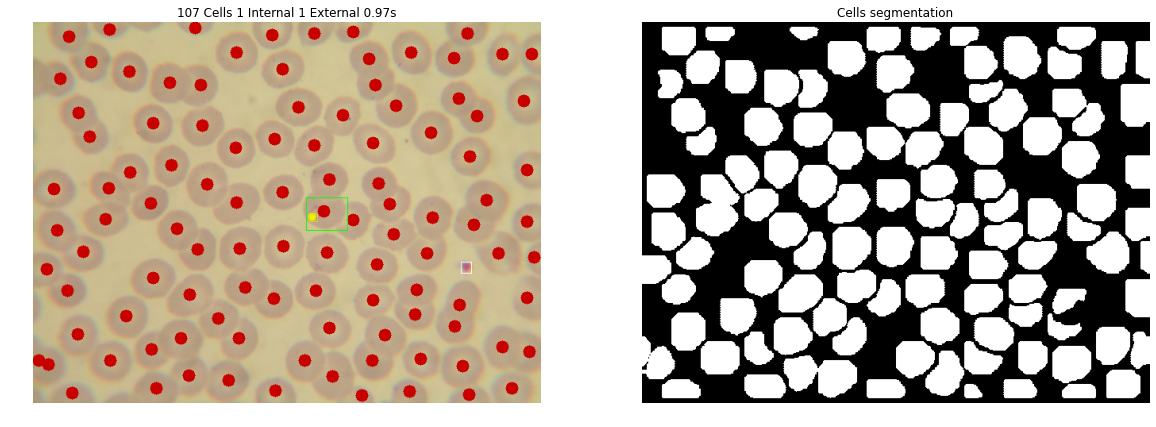

In [75]:
from ipynb.fs.full.general_functions import *
from ultralytics import YOLO


def yolov8_method(path, validation_type, mark_parasites=True):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    
    #read in colors
    img = get_image(path=path,mode=1)
    
    if os.path.isfile("yolov8/best-yolov8-300-seg.pt"):
        model = YOLO("yolov8/best-yolov8-300-seg.pt")
    else:
        model = YOLO("segmentation_methods/yolov8/best-yolov8-300-seg.pt")
        
    results = model(path, conf=0.6 )
    
    #mark
    res = results[0]
    for box in res.boxes.xywhn:
        x,y,w,h = box
        
        x, y = x * img.shape[1], y * img.shape[0]
        w, h = w * img.shape[1], h * img.shape[0]
        
        x,y,w,h = int(x),int(y),int(w),int(h)
        img = cv2.circle(img, (x,y), 8, (200,0,0), -1)
    
    
    #mask
    cells = 0
    cell_mask = np.zeros_like(np.asarray(res.masks.data[0].cpu()), dtype='bool')
    for mask in res.masks.data:
        cells += 1
        mask = np.asarray(mask.cpu(), dtype='bool')
        cell_mask = np.ma.mask_or(cell_mask, mask )

    cell_mask = cell_mask.astype(np.uint8)
    

    name = "YOLOv8"
    method_ext = "_yolov8"
    
    #hsv mask
    par_mask, par_mask_dilated = hsv_par_mask(img)

    
    #Marca os parasitas
    cell_mask = cv2.resize(cell_mask,(640,480))
    if mark_parasites:
        img, internal, external = parasites_mark(img, par_mask, cell_mask)
    else:
        internal, external = 0,0
        
    end = time.time()
    
    img = cv2.resize(img, (640,480))
    cell_mask = cv2.resize(cell_mask, (640,480))

    passTime = "%.2fs" % (end-start)

    #save results
    save_results(path,name,cells,internal,external, passTime, img, method_ext, validation_type)
    
    return (img, cell_mask), (cells, internal, external, passTime)


if __name__ == '__main__':
    #PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    PATH = "../blood_samples/samples/blood_smear_15.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    #PATH = '../blood_samples/samples/blood_smear_3.JPG'
    images, stats = yolov8_method(PATH, NO_VALIDATION, mark_parasites=True)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()